# Compare Celerite fit to Chelsea fit : real light curves 

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
import seaborn as sns
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Using the results from most recent run : `190409_Celerite_real_Jeff1.npy`

In [4]:
# PRE-PROCESS the Celerite results from numpy dic --> astropy table
# and Chelsea results from a dat w/o SFinf --> astropy table 

# read in the results of just fitting the real LCs 
#fname = '../code/190228_Celerite_real_Jeff1.npy'
fname = '190409_Celerite_real_Jeff1.npy'
r = np.load(fname).item() # it's only SDSS, SDSS-PS1 : two segments 

# convert a dict to a table, choosing relevant parts... 
seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)
t1_ = unique(t1, keys='lcname', keep='first')

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)
t2_ = unique(t2, keys='lcname', keep='first')

celerite =  join(t1_,t2_, keys='lcname', table_names=[seg[0] ,seg[1]])

celerite.write(fname[:-4]+'.txt', format='ascii')
print('Saved as ',fname[:-4]+'.txt' )

Saved as  190409_Celerite_real_Jeff1.txt


Plot $\tau_{SDSS}$ vd $\tau_{SDSS-PS1}$ : 

In [2]:
%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(7,7))
ax.hexbin(np.log10(celerite['tauEXP_sdss-ps1']), 
          np.log10(celerite['tauEXP_sdss']), extent=(1.5,3.5,1.5,3.5), 
         gridsize=30)
ax.set_xlabel(r'$\log_{10}{(\tau_{\mathrm{SDSS-PS1}})}$')
ax.set_ylabel(r'$\log_{10}{(\tau_{\mathrm{SDSS}})}$')
x  = np.linspace(1.5,3.5,100)
ax.plot(x,x,ls='--',lw=4, color='red')
ax.set_title('REAL DATA', fontsize=18)
figname = 'Celerite_'+fname[:6]+'_timescales.png'
print(figname)
plt.savefig(figname, bbox_inches='tight', dpi=100)

NameError: name 'plt' is not defined

'190409'

In [4]:
# For some reason some light curves have been fit multiple times.
# Can't see atm why, but the results are 
# the same , so just remove duplicates 
names, count = np.unique(t2['lcname'], return_counts=True)
t2[t2['lcname'] == names[count==3][3]]

lcname,length,sigmaEXP,sigmaMAP,tauEXP,tauMAP
str11,float64,float64,float64,float64,float64
1708411.txt,5232.903164999996,0.2294545961415032,0.1904710048462376,1915.3791160875835,1041.994821295959
1708411.txt,5232.903164999996,0.2294545961415032,0.1904710048462376,1915.3791160875835,1041.994821295959
1708411.txt,5232.903164999996,0.2294545961415032,0.1904710048462376,1915.3791160875835,1041.994821295959


Just plot Celerite, and compare how the overall distribution shift : 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median log10(sigma_sdss-ps1/sigma_sdss)= 0.04697180801399162
Mean log10(sigma_sdss-ps1/sigma_sdss)= 0.08181728949808303
Median log10(tau_sdss-ps1/tau_sdss)= -0.33765949998410066
Mean log10(tau_sdss-ps1/tau_sdss)= -0.4346734013089568


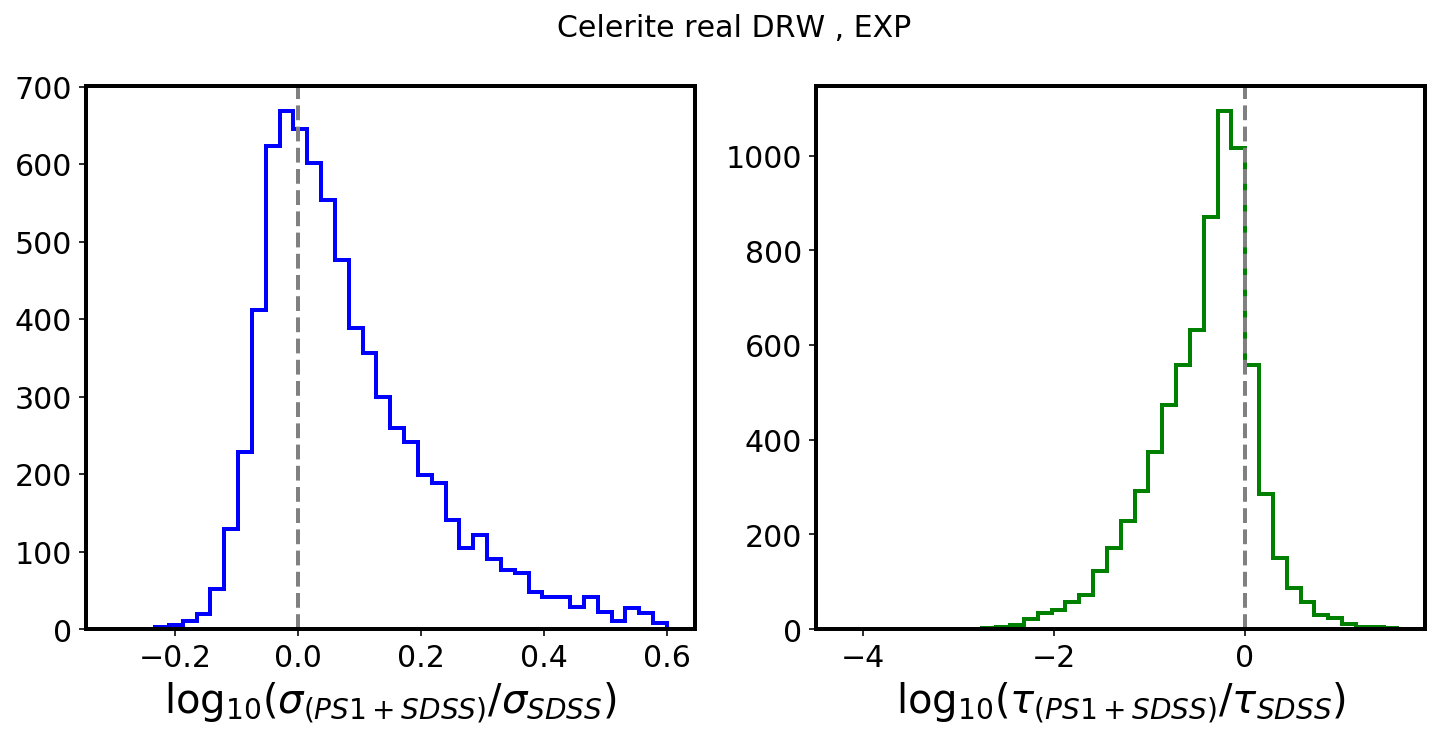

In [59]:
%config InlineBackend.figure_format='retina'
# plot changes in tau only for QSO for which Chelsea was more certain...

s82r = celerite
# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

fit='EXP'

fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

i = 0

labels = {'sigma': r'$\log_{10}{(\sigma_{(PS1+SDSS)} / \sigma_{SDSS})}$',
         'tau':r'$\log_{10}{(\tau_{(PS1+SDSS)} / \tau_{SDSS})}$'}

#m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
#m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
#m4 = s82r['edge'] == 0 
#m = m2&m3&m4

m = celerite['tauEXP_sdss'] > 5

ranges = {'sigma':[-0.3,0.6], 'tau':[-4.2,1.6]}

for q in ['sigma','tau']:
    m = s82r['tau'+fit+'_sdss-ps1'] > 5 
    x = (s82r[q+fit+'_sdss-ps1'][m] )/ s82r[q+fit+'_sdss'][m]
    ax[i].hist(np.log10(x), histtype='step', 
               bins=40, range=ranges[q], color = colors[i],lw=2) 
    
    print('Median log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.median(np.log10(x)))
    print('Mean log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.mean(np.log10(x)))
    
    ax[i].set_xlabel(labels[q])
    ax[i].axvline(0, lw=2, ls='--', c='grey')
    i += 1 

fig.suptitle('Celerite real DRW , '+ fit , fontsize = 15)
plt.savefig('Celerite_real_DRW_EXP_compare_tau_NEW.png', bbox_inches='tight')

Just Celerite:  what are the $\rho_{out}$ values ? 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Text(0.5, 0, '$\\rho_{fit} = \\tau_{\\mathrm{fit}} / \\mathrm{baseline}$')

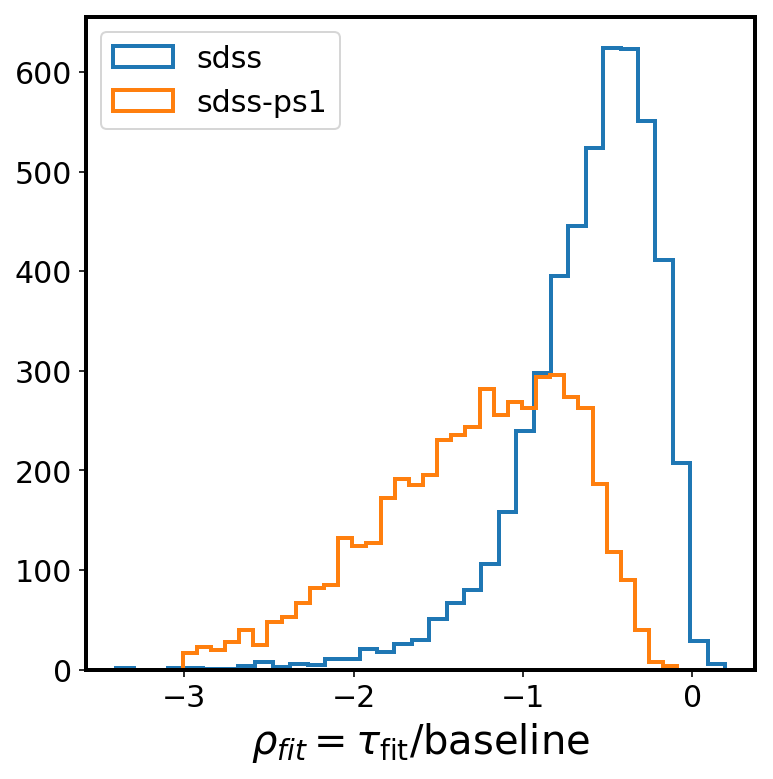

In [57]:
segs = ['sdss', 'sdss-ps1']
m = s82r['tauEXP_sdss-ps1'] > 5
fig,ax = plt.subplots(1,1,figsize=(6,6))
for seg in segs:
    rho = s82r['tauEXP_'+seg][m] / s82r['length_'+seg][m]
    ax.hist(np.log10(rho), histtype='step',lw=2, label=seg, bins=35)
ax.legend(loc='upper left')
ax.set_xlabel(r'$\rho_{fit} = \tau_{\mathrm{fit}} / \mathrm{baseline}$')

Add to Celerite Shen2008 (DBQSO), and Shen2011. Then also add Chelsea's r-band results 

Crossmatch Chelsea's r-band results to Celerite results : 

In [10]:

# add a column with int  DR7  dbID  for SDSS QSO 
dbID = np.asarray([x[:-4] for x in celerite['lcname']]).astype(int)
celerite['dbID']  = dbID

# add the info about qso from DR7 catalog to have ra, dec 
#  SDSS s82r  9258  DR7 QSOs from Shen+2008
# from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_s82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dr7 = Table.read(File, format='ascii', names = colnames)
celerite_dbqso = join(celerite, dr7, keys='dbID')

name = fname[:-4]+'_radec.txt'
celerite_dbqso.write(name, format='ascii', overwrite=True) 
print('Added to Celerite DBQSO. Saved as ', name)


# read in Shen+2011 to add to the resutls ....
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]


cat1 = SkyCoord(ra=celerite_dbqso['ra']*u.degree, 
                dec=celerite_dbqso['dec']*u.degree)
cat2 = SkyCoord(ra=shen2011['RA']*u.degree,
                dec=shen2011['DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
# Celerite x-matched to Shen2008 (DBQSO) and Shen2011 - all catalogs 
celerite_cats = hstack([celerite_dbqso, shen2011[idx]])
name = fname[:-4]+'_Shen2008-2011.txt'
celerite_cats.write(name, format='ascii', overwrite=True)
print('Added to Celerite DBQSO and Shen2011. Saved as ', name)

# read in Chelsea's results ... 
s82drw = Table.read('../code/s82drw_r.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
# add a column with SFinf in mags 
# sigmahat  =  SFinf / sqrt(tau)
# but she did it for tau in years ,
# so need to convert to days 
s82drw['SFinf'] = np.power(10,s82drw['log10sigmahat']) *\
     np.sqrt(np.power(10,s82drw['log10tau']) / 365.)
    
    
# add a column with lambda RF 
s82drw['lambdaRF'] = 6250 /  (1.+ s82drw['redshift'])
s82drw.write('s82drw_r_table.txt', format='ascii', overwrite='True')


# Read in Chelsea's r-band results 
# And Celerite real LC results,
# cross-matched with DB_QSO_DR7  for ra,dec 
#celerite = Table.read('190228_Celerite_real_Jeff1_2000_table_radec.txt', format='ascii')
#chelsea = Table.read('s82rdrw_r_table.txt', format='ascii')
celerite = celerite_cats
chelsea = s82drw

# cross-match Celerite to Chelsea 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=chelsea['ra']*u.degree,
                dec=chelsea['dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
s82r = hstack([celerite, chelsea[idx]])
name = fname[:-4]+'_Shen2008-2011_s82drw_r.txt'
s82r.write(name, format='ascii', overwrite='True')
print('Added to Celerite DBQSO, Shen2011 and Chelsea s82drw r-band . Saved as ', name)




Added to Celerite DBQSO. Saved as  190409_Celerite_real_Jeff1_radec.txt
Added to Celerite DBQSO and Shen2011. Saved as  190409_Celerite_real_Jeff1_Shen2008-2011.txt
Added to Celerite DBQSO, Shen2011 and Chelsea s82drw r-band . Saved as  190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt


Note: of 6444 Quasars for which I have combined light curves,  **only 4828 **Chelsea would trust, because they don't have runaway timescales and the likelihood for DRW is better than the likelihood for noise (this is for SDSS-PTF-PS1-CRTS inner join).

Note: if using the outer join, i.e. eg. light curves that have SDSS-PS1 data, but not CRTS, or PTF,  we boost the numbers to 7624 that Chelsea would have trusted (from her fits) of 

In [8]:
#s82r = Table.read('190409_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
m4 = s82r['edge'] == 0 

m = m2&m3&m4
print(np.sum(m), ' of ', len(m))
# haha! now there are 6975 QSO that Chelsea would have trusted ... 

6975  of  9246


In [10]:
#s82r

Plot the residuals  $\Delta(\mathrm{Chelsea}-\mathrm{Celerite})$ : 

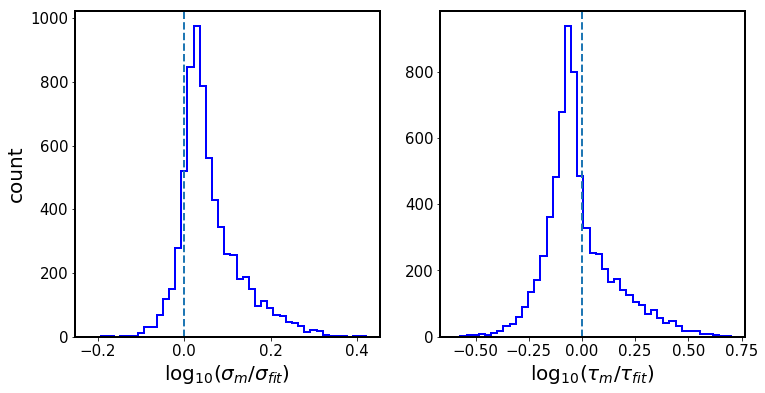

In [6]:
%matplotlib inline
import matplotlib.lines as mlines
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

fig,ax = plt.subplots(1,2,figsize=(12,6))
x1a =  s82r['SFinf'][m] / np.sqrt(2)
x1b = np.power(10, s82r['log10tau'][m]) 
i =0 
for f in ['EXP']:
    for seg in ['sdss']:
        
        x2 = s82r['sigma'+f+'_'+seg][m] 
        #ax[0].hist(np.log10(x1-x2), histtype='step')
        ax[0].hist(np.log10(x1a/x2), range=(-0.22,0.42),histtype='step',lw=2,
                  color = colors[i], bins=45)
        x2 = s82r['tau'+f+'_'+seg][m]
        ax[1].hist(np.log10(x1b/x2), range=(-0.6,0.7),histtype='step',lw=2,
                  color = colors[i],bins=45)
        
        line = mlines.Line2D([], [],  color=colors[i], label=f+'_'+seg,lw=2)
        ax_legend_handles.append(line)
        i += 1 
        
        
ax[0].set_ylabel('count')

#ax[1].legend(loc='upper right', handles = ax_legend_handles,
#             bbox_to_anchor=(1.0, 1.0),
#             ncol=1, fancybox=True, shadow=True, fontsize=13 ) 
#for seg in ['sdss', 'sdss-ps1']:
    
    #ax[1].hist(np.log10(x1-x2), histtype='step')
   # ax[1].hist(np.log10(x1/x2), range=(-0.5,1.1),histtype='step',lw=2)
ax[0].axvline(0, ls = '--', lw=2)
ax[1].axvline(0,ls = '--', lw=2)
ax[0].set_xlabel(r'$\log_{10}{\left( \sigma_{m} / \sigma_{fit} \right)}$')
ax[1].set_xlabel(r'$\log_{10}{\left( \tau_{m} / \tau_{fit}\right)}$')
plt.savefig('Compare_Chelsea_r-band_Celerite_SDSS_EXP_NEW.png', bbox_inches='tight')

I'm not  sure if I should expect that there will be a definite trend with the addition of the PS1 data ... 

In [7]:
s82r

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64
70.txt,3336.9332799999975,0.06622421705058883,0.05984751944546515,122.6490220515577,43.947398211560085,5147.007797999999,--,0.1414213562373095,--,575.0000000000001,70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116,301,2.169302,1.238649,1.073,-23.901,0.0,1.1926,1.90162,-0.686379,1.70316,3.08136,-0.957464,-0.627884,0,138.926,117.218,136.073,20.2857,60,0.09622425731393176
98.txt,2582.962741999996,0.17768456506773989,0.1425442932431927,926.094822794734,346.4224029622469,4767.016951999998,0.17310108214083317,0.15534946096966964,366.7595534657186,195.0728544419519,98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183,144,1.091028,0.962126,0.7867,-23.399,0.0,1.27857,2.72909,-0.7177,2.6183,4.47248,-0.840168,-0.660262,0,123.092,75.9121,122.524,19.8702,52,0.23211252059810764
233.txt,3321.0338420000044,0.10075751425165866,0.08457207262730722,656.8411333494078,193.68268108139895,5505.090184000001,0.08836165515962953,0.08481144613166788,23.17606014197748,15.432798620779016,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.12325897950662115
1018.txt,3336.9333019999976,0.19658989986620978,0.15925866404367295,717.7566916392584,289.67763034974274,5511.071033,0.21944178126621033,0.2084173212910267,2.326795898528782,34.18145321920661,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.33696948003053717
1310.txt,3321.033924000003,0.04259839263300376,0.03745187919140339,383.23865805003277,145.46098372293594,5505.090513000003,0.16782713150619089,0.14034153752344863,1950.7661616699622,982.1410477550927,1310,0.221552,-0.292485,36,-26.451,-26.974,2.7563,9.361,46.76,20.707,19.663,19.61,19.705,19.529,0.174,36,0.221552,-0.292485,2.7563,-26.451,9.361,0.896713,2.53532,-1.15549,2.3373,4.25247,-1.32342,-1.07652,0,167.706,147.08,166.563,19.5994,56,0.06776782820446034
1327.txt,3336.933323999998,0.09386092410592684,0.08008109991945163,401.9078025109211,193.64023845008344,5511.074029999996,0.1406114535927338,0.13532387127358367,14.78234481042374,11.691528536439487,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,49,0.28137,0.686984,1.3988,-24.917,8.817,0.870333,2.5301,-0.832748,2.3953,4.21627,-0.94041,-0.795638,0,175.03,103.201,173.65,19.72,63,0.14163010195042328
1540.txt,3321.033884999997,0.09302541943027218,0.07824425043422796,2584.5762528494092,1723.6989668554659,5141.047904999999,0.40943243061572965,0.40339439488823703,1.0033014997856988,1.0,1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122,370,2.607954,0.913245,2.8473,-27.263,0.0,1.11517,5.0,-1.325,3.43892,4.71963,-1.41087,-1.21987,1,165.111,106.772,165.11,18.961,52,0.7831655362322905
1580.txt,3336.9332989999966,0.10291795105010643,0.08951536556977513,280.9587329328324,138.42844568239968,5147

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10


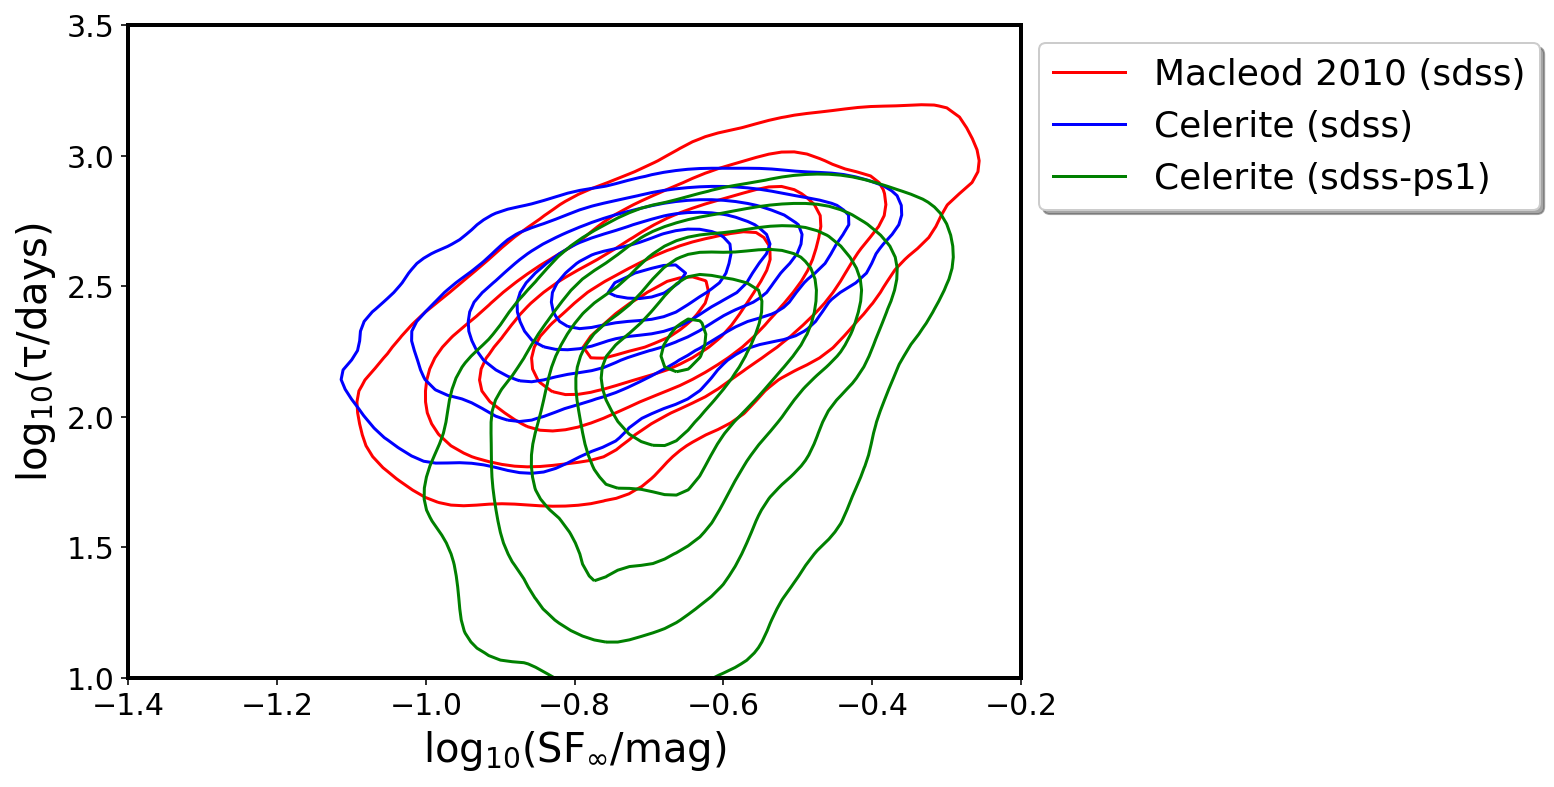

In [11]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
# do the same selection as Chelsea
m1 = (s82r['log10sigmahat'] > -10)*(s82r['log10tau'] > -10)
m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
m4 = s82r['edge'] == 0 

# choose the same extent as Fig.3 MacLeod+2010 
extent = [-1.5,0, 0,5]

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax_legend_handles = []


# If Chelsea's were already RF ... 
# tRF = np.power(10,s82r['log10tau'])
# x = np.log10(s82r['SFinf'])
# y = np.log10(tRF)
# mx = (extent[0] < x) * (x < extent[1])
# my = (extent[2] < y) * (y < extent[3])

# m = mx&my&m1&m2&m3&m4 
# sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
#             linestyles='-', linewidth=2, cmap=None, colors='purple',)
# line = mlines.Line2D([], [],  color='purple', label='ChelseaRF')
# ax_legend_handles.append(line)

# Plot Chelsea's results ( s82rdrw...  - only r-band )
# # assuming tau is obs : conv to restframe by dividing by redshift
red = 'REDSHIFT' # use redshift from Shen2011 ideally ... 
tobs = np.power(10,s82r['log10tau'])
trest = tobs / (1+s82r[red])

x = np.log10(s82r['SFinf'])
y = np.log10(trest) 

mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])

m = mx&my&m1&m2&m3&m4 


sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
            linestyles='-', linewidth=2, cmap=None, colors='r',)
line = mlines.Line2D([], [],  color='r', label='Macleod 2010 (sdss)')
ax_legend_handles.append(line)

 
    
# Plot Celerite results ... 
for seg,color  in zip(['sdss','sdss-ps1'], ['blue','green']):
    sfinf = np.sqrt(2) * s82r['sigmaEXP_'+seg]
    tauOBS = s82r['tauEXP_'+seg]
    tauRF = tauOBS / (1+s82r[red])
    x = np.log10(sfinf)
    y = np.log10(tauRF)
    m5 = tauOBS > 2
    m = mx&my&m1&m2&m3&m4&m5
    #ax.scatter(x[m], y[m], s=0.05)
    sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
                linestyles='-', linewidth=2, cmap=None, colors=color, )
    line = mlines.Line2D([], [],  color=color, label='Celerite ('+seg+')')
    ax_legend_handles.append(line)


ax.legend(loc='upper left', handles = ax_legend_handles, bbox_to_anchor=(1,1),
            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 


ax.set_xlabel(r'$\log_{10}{(\mathrm{SF_{\infty}/mag})}$')
ax.set_ylabel(r'$\log_{10}{(\mathrm{\tau/ days})}$')
ax.set_xlim(-1.4, -0.2)
ax.set_ylim(1,3.5)

plt.savefig('MacLeod2010_Fig3_restframe_NEW.png', bbox_inches='tight', dpi=100)

Show the ratio of green (SDSS-PS1) to blue (SDSS) : 
    

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


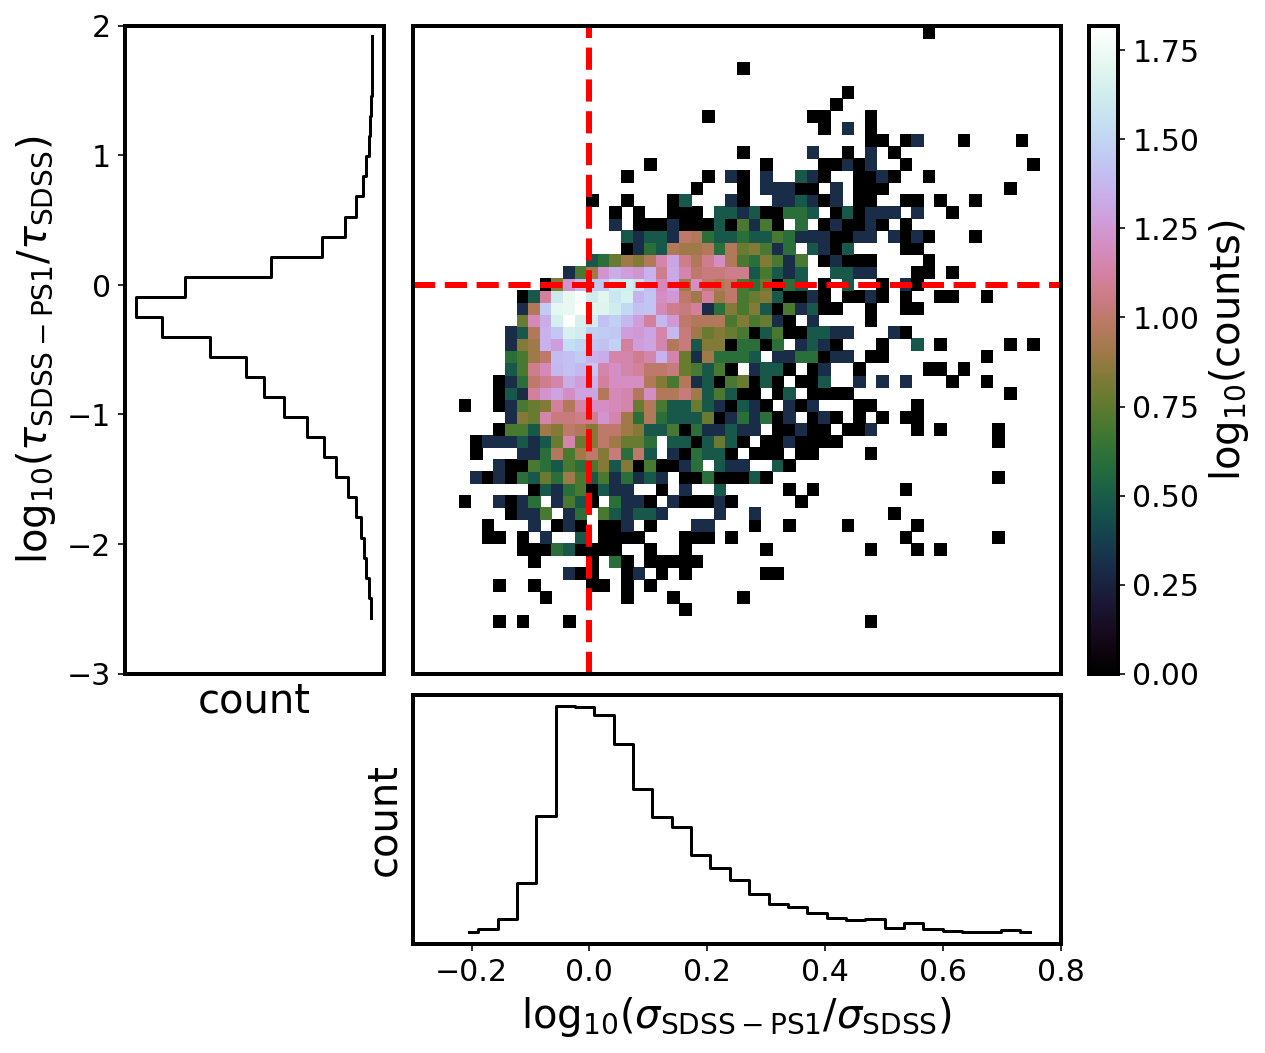

In [62]:
%matplotlib inline

# this code is based on figures 
# http://www.astroml.org/book_figures/chapter5/fig_likelihood_uniform.html#book-fig-chapter5-fig-likelihood-uniform
# and
# http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html#book-fig-chapter5-fig-cauchy-mcmc

from scipy.stats import binned_statistic_2d
fig = plt.figure(figsize=(10, 7.5))

xmin,xmax = -0.3,0.8
ymin,ymax = -3, 2 
# the main plot 
ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
# SFinf_sdss_ps1 / SFinf_sdss = sigma_sdss_ps1 / sigma_sdss
x = np.log10(s82r['sigmaEXP_sdss-ps1'] / s82r['sigmaEXP_sdss'] )
# the redshift correction cancels out 
# tauRF = tauOBS / (1+z)
# tauRF_1  /  tauRF_2  = (tauOBS_1 / (1+z) ) * ((1+z) / tauOBS_2) = 
             # tauOBS_1 / tauOBS_2
y = np.log10(s82r['tauEXP_sdss-ps1']/s82r['tauEXP_sdss']) 

m5 = s82r['tauEXP_sdss-ps1'] > 5


mx = (xmin<x) & (x<xmax)
my = (ymin<y) & (y<ymax)

m = mx&my&m1&m2&m3&m4&m5&mx&my

stats = binned_statistic_2d(x[m], y[m], values = x[m], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,np.log10(z_masked), cmap='cubehelix')  
# np.log10(z_masked) gives log counts
cax = plt.axes([0.82, 0.35, 0.02, 0.6])
cb = plt.colorbar(mappable  = image, cax=cax)
cb.set_label(r'$\log_{10}(\mathrm{counts}) $')
#plt.clim(-7, 0)

ax.axhline(0, lw=3, ls='--', color='red')
ax.axvline(0, lw=3,ls='--', color='red')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# histograms .. 
bins = 30 
# bottom axis 
ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
hist, bin_edges = np.histogram(x[m], bins=bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
ax1.plot(bin_centers, hist,'-k', drawstyle='steps-mid')
ax1.set_xlabel(r'$\log_{10}{(\sigma_{\mathrm{SDSS-PS1}} / \sigma_{\mathrm{SDSS}})}$')
ax1.set_ylabel('count')
ax1.set_xlim(xmin,xmax)


# left axis 
hist, bin_edges = np.histogram(y[m], bins=bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
ax2.plot(hist, bin_centers, '-k', drawstyle='steps-mid')
ax2.set_xlabel('count')
ax2.set_ylabel(r'$\log_{10}{(\tau_{\mathrm{SDSS-PS1}} / \tau_{\mathrm{SDSS}})}$')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
ax2.set_ylim(ymin,ymax)

plt.savefig('Celerite_EXP_J1_ratios_sdss-ps1.png', bbox_inches='tight', dpi=100)

In [51]:
hist, bin_edges = np.histogram(x, bins=50)
(bin_edges[1:]+bin_edges[:-1])/2

array([-2.07227715e-01, -1.72640799e-01, -1.38053883e-01, -1.03466966e-01,
       -6.88800499e-02, -3.42931335e-02,  2.93782848e-04,  3.48806992e-02,
        6.94676156e-02,  1.04054532e-01,  1.38641448e-01,  1.73228365e-01,
        2.07815281e-01,  2.42402198e-01,  2.76989114e-01,  3.11576030e-01,
        3.46162947e-01,  3.80749863e-01,  4.15336779e-01,  4.49923696e-01,
        4.84510612e-01,  5.19097529e-01,  5.53684445e-01,  5.88271361e-01,
        6.22858278e-01,  6.57445194e-01,  6.92032111e-01,  7.26619027e-01,
        7.61205943e-01,  7.95792860e-01,  8.30379776e-01,  8.64966692e-01,
        8.99553609e-01,  9.34140525e-01,  9.68727442e-01,  1.00331436e+00,
        1.03790127e+00,  1.07248819e+00,  1.10707511e+00,  1.14166202e+00,
        1.17624894e+00,  1.21083586e+00,  1.24542277e+00,  1.28000969e+00,
        1.31459661e+00,  1.34918352e+00,  1.38377044e+00,  1.41835735e+00,
        1.45294427e+00,  1.48753119e+00])

In [52]:
bin_edges

array([-0.22452117, -0.18993426, -0.15534734, -0.12076042, -0.08617351,
       -0.05158659, -0.01699968,  0.01758724,  0.05217416,  0.08676107,
        0.12134799,  0.15593491,  0.19052182,  0.22510874,  0.25969566,
        0.29428257,  0.32886949,  0.3634564 ,  0.39804332,  0.43263024,
        0.46721715,  0.50180407,  0.53639099,  0.5709779 ,  0.60556482,
        0.64015174,  0.67473865,  0.70932557,  0.74391249,  0.7784994 ,
        0.81308632,  0.84767323,  0.88226015,  0.91684707,  0.95143398,
        0.9860209 ,  1.02060782,  1.05519473,  1.08978165,  1.12436857,
        1.15895548,  1.1935424 ,  1.22812931,  1.26271623,  1.29730315,
        1.33189006,  1.36647698,  1.4010639 ,  1.43565081,  1.47023773,
        1.50482465])

Take Celerite data for SDSS,  and SDSS+PS1 : fit for the quantities from Table1

Read Chelsea multi-band data into a dictionary ( for MacLeod2011, Fig.13) 

In [32]:
# read in Shen+2011 to add to her resutls ....
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# add DBQSO M_i_corr , since it's slightly different than MI_Z2 ...
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)

s82ugriz = {}
# wavelength of observed bandpass 
lambdaobs = {'u':3520, 'g':4800, 'r':6250, 'i':7690, 'z' : 9110 }

for f in 'ugriz':
    s82ugriz[f] = Table.read('../code/s82drw_'+f+'.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
    
    # her selection (chapter 3, macleod2010) was to use only those 
    # where 
    print('\nFor ', f , ' band starting with ', len(s82ugriz[f]))
    m1 = s82ugriz[f]['Npts'] > 10 
    print('Npts>10 ', np.sum(m1))
    m2 = s82ugriz[f]['Plike'] - s82ugriz[f]['Pnoise'] > 2 
    print('Plike - Pnoise  > 2 ' , np.sum(m2))
    m3 = s82ugriz[f]['Plike'] - s82ugriz[f]['Pinf'] > 0.05 
    print('Plike - Pinf > 0.05  ', np.sum(m3))
    m4 = s82ugriz[f]['edge'] == 0 
    print('edge == 0  ', np.sum(m4))
    m = m1&m2&m3&m4
    print('Combined kept : ', np.sum(m))
    s82ugriz[f] = s82ugriz[f][m]
    
    # make a column saying what the middle of the observed filter 
    # corresponds to in QSO rest frame ... ( sec. 5.1)       tface
    s82ugriz[f]['lambdaRF'] = lambdaobs[f] /  (1.+ s82ugriz[f]['redshift'])
    
    # convert tau  to restframe  (SF doesn't need that since amplitude 
    # is not time-dilated )
     
    s82ugriz[f]['SFinf']  = np.power(10,s82ugriz[f]['log10sigmahat']) * \
                  np.sqrt(np.power(10,s82ugriz[f]['log10tau']) / 365.)  
        # # b/c her sigma hat in mag / sqrt(year)  rather than mag / sqrt(days), 
        # and tau is in days 
    s82ugriz[f]['tauRF'] = np.power(10,s82ugriz[f]['log10tau'])  /\
                 (1.+ s82ugriz[f]['redshift'])
    
    # no need to move SFinf to Rest Frame, since it is not affected in the 
    # slightest by using a different frame ... 
    #s82[f]['SFinfRF'] = s82[f]['SFinf'] / (1.+ s82[f]['redshift'])

    
    # make a column with SFinf,  tau  converted to  4000 angstroms using 
    # Chelsea's coefficients 
    s82ugriz[f]['SFinf4000'] = s82ugriz[f]['SFinf'] *\
          np.power(4000 / s82ugriz[f]['lambdaRF'], -0.479)
    s82ugriz[f]['tau4000'] = s82ugriz[f]['tauRF'] *\
        np.power(4000 / s82ugriz[f]['lambdaRF'] , 0.17 )

    
    # add info about Shen+2011   Lbol,  MBH,  etc.  
    cat1 = SkyCoord(ra=s82ugriz[f]['ra']*u.degree, 
                dec=s82ugriz[f]['dec']*u.degree)
    cat2 = SkyCoord(shen2011['RA']*u.degree,shen2011['DEC']*u.degree, 
                       frame='icrs') 
    # grab shen2011 values for BH mass, Lbol, Redshift.... 
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82ugriz[f]['d2d_asec_Shen11'] = sep2d.value*3600

    s82ugriz[f]= hstack([s82ugriz[f], shen2011[idx]])

    # add DBQSO 
    cat1 = SkyCoord(ra=s82ugriz[f]['ra']*u.degree, 
                  dec=s82ugriz[f]['dec']*u.degree)
    cat2 = SkyCoord(dbqso['ra']*u.degree,dbqso['dec']*u.degree, 
                       frame='icrs') 
    # add DBQSO 'M_i_corr'
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82ugriz[f]['d2d_asec_DBQSO'] = sep2d.value*3600
    s82ugriz[f]= hstack([s82ugriz[f], dbqso[idx][['M_i_corr']]])
   
# save the dictionary ...
np.save('s82ugriz_shen2011_dbqso_dic', s82ugriz)


For  u  band starting with  9258
Npts>10  9135
Plike - Pnoise  > 2  8402
Plike - Pinf > 0.05   7827
edge == 0   8148
Combined kept :  7014

For  g  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  9130
Plike - Pinf > 0.05   7641
edge == 0   8180
Combined kept :  7408

For  r  band starting with  9258
Npts>10  9139
Plike - Pnoise  > 2  9128
Plike - Pinf > 0.05   7103
edge == 0   7823
Combined kept :  6871

For  i  band starting with  9258
Npts>10  9138
Plike - Pnoise  > 2  8964
Plike - Pinf > 0.05   7213
edge == 0   7868
Combined kept :  6814

For  z  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  7505
Plike - Pinf > 0.05   6719
edge == 0   7365
Combined kept :  5111


In [2]:
# This is Chelsea ugriz data, x-matched with DBQSO and Shen2011...
s82ugriz = np.load('s82ugriz_shen2011_dbqso_dic.npy').item()

Read Celerite data, overplot on the plot of Fig.13, showing wavelength dependence of timescale and asymptotic amplitude ... 

In [3]:
# This is Celerite x-matched with DBQSO and Chelsea's r-band data 
# earlier:  using 190228  (inner join of SDSS to CRTS,PTF,PS1) , 
# now : using 190409  (outer join of SDSS to CRTS,PTF,PS1, using 2000 more QSO )
s82r = Table.read('190409_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')


## add Shen2011
shen2011 = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
m = shen2011[abs(shen2011['DEC']) < 1.5]
sel = m[['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2' ]]

# cross-match 
cat1 = SkyCoord(ra=cd['ra']*u.degree,  dec=cd['dec']*u.degree)
cat2 = SkyCoord(ra=sel['RA']*u.degree, dec=sel['DEC']*u.degree,  frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
cd2 = hstack([cd, sel[idx]])


# add a column with lambdaRF
lambdaobs = {'u':3520, 'g':4800, 'r':6250, 'i':7690, 'z' : 9110 }
s82r['lambdaRF'] = lambdaobs['r'] /  (1.+ s82r['redshift_1'])    
#s82r

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


sdss red
sdss-ps1 orange


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


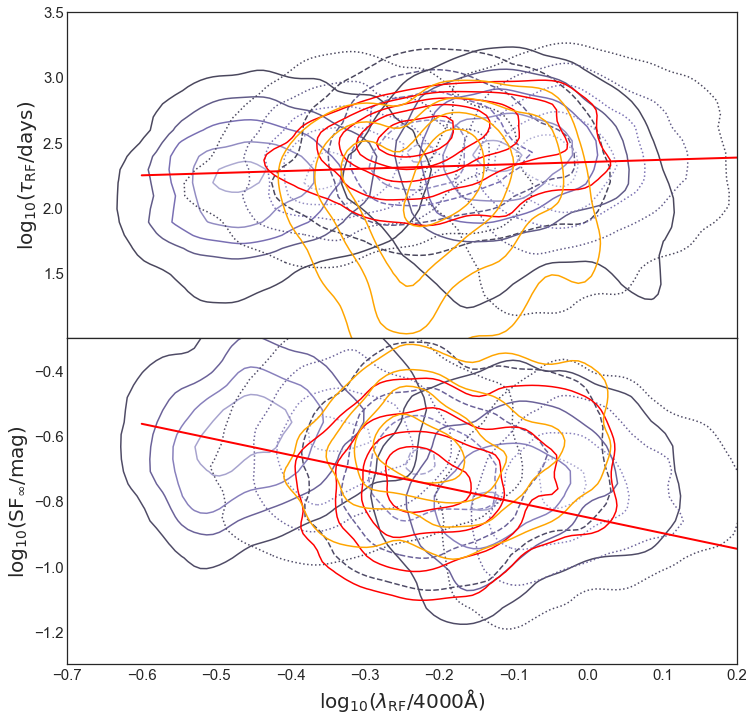

In [8]:
%matplotlib inline
# Make a plot like Fig.13 : 
# rest-frame wavelength  vs tau_RF and SFinf  ... 
def convert_to_stdev(z):
    shape = z.shape
    z = z.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(z)[::-1]
    i_unsort = np.argsort(i_sort)

    z_cumsum = z[i_sort].cumsum()
    z_cumsum /= z_cumsum[-1]

    return z_cumsum[i_unsort].reshape(shape)



ls = {'u':'-',  'g':':', 'r': '--', 'i': '-', 'z': ':' }
lw = {'u':3,    'g': 1,  'r':  2  , 'i': 1  , 'z': 3}
xlims = [-0.7,0.2]
ylims = {0: [1,3.5] , 1:[-1.3,-0.3]}
n_levels = 5 

fig,ax = plt.subplots(2,1,figsize=(12,12))

sns.set_style("white")
# seaborn contour plot line style ...
# https://stackoverflow.com/questions/49671053/seaborn-changing-line-styling-in-kdeplot

seg = 'sdss-ps1' # -ptf

# plot the background of Chelsea's results 
for f in  'ugriz' : 
    x  = np.log10(s82ugriz[f]['lambdaRF'] / 4000 )
    y1 = np.log10(s82ugriz[f]['tauRF'])
    y2 = np.log10(s82ugriz[f]['SFinf']) # np.log10(s82[f]['SFinfRF'])
    
    # Chelsea 
    sns.kdeplot(x,y1, n_levels=n_levels, cmap="Purples_d", ax=ax[0],
               linestyles=ls[f], linewidth=lw[f])
    sns.kdeplot(x,y2, n_levels=n_levels, cmap="Purples_d", ax=ax[1],
               linestyles=ls[f], linewidth=lw[f])

    
# plot Chelsea's fits 
x = np.linspace(-0.6, 0.2, 100)
ax[0].plot(x , 0.17 *  x + 2.35, c='red', lw=2 )
ax[1].plot(x, -0.479 * x - 0.85 , c='red', lw=2)

    
# Celerite : plot sdss and sdss-ps1 
segs = ['sdss', 'sdss-ps1']
for seg, c in zip(segs, ['red', 'orange']):
    print(seg,c)
    tau = s82r['tauEXP_'+seg]

    tauRF = tau / (1. + s82r['redshift_1'])
    SFinf = np.sqrt(2) * s82r['sigmaEXP_'+seg] 

    m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
    m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
    m4 = s82r['edge'] == 0 
    m = m2&m3&m4  #m = tau > 3  

    x = np.log10(s82r['lambdaRF'][m] / 4000)
    y1 = np.log10(tauRF[m])
    y2 = np.log10(SFinf[m])
    sns.kdeplot(x,y1, n_levels=n_levels, ax=ax[0],
               linestyles='-', cmap=None, colors=c)
    sns.kdeplot(x,y2, n_levels=n_levels, ax=ax[1],
               linestyles='-', cmap=None, colors=c)


ax[1].set_xlabel(r'$\log_{10}{(\lambda_{\mathrm{RF}} / 4000 \mathrm{\AA})}$')
ax[0].set_ylabel(r'$\log_{10}{(\tau_{\mathrm{RF}} / \mathrm{days})}$')
ax[1].set_ylabel(r'$\log_{10}{(\mathrm{SF}_{\infty} / \mathrm{mag})}$')
ax[0].set_xlim(xlims)
ax[1].set_xlim(xlims)
ax[0].set_ylim(ylims[0])
ax[1].set_ylim(ylims[1])
# remove bottom tick from first axis 
ax[0].set_yticks(ax[0].get_yticks()[1:])

# remove bottom and top ticks  from second axis 
ax[1].set_yticks(ax[1].get_yticks()[1:-1])

# remove xticks from top axis 
ax[0].set_xticks([])


fig.subplots_adjust(hspace=0)
plt.savefig('macleod2010_Fig13_kdeplot_Chelsea_cut_NEW.png', 
            bbox_inches='tight', dpi=100)
